In [1]:
!pip install opencv-python torchsummary scikit-learn torchviz utils

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [2]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import utils
from torch.nn.functional import one_hot
from torchvision.utils import save_image
from torch.autograd import Variable
from torch.utils.data import SubsetRandomSampler

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_arch_list(), device)

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86'] cuda


In [4]:
from __future__ import print_function
import argparse
import datetime
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import clear_output
from tqdm import tqdm
import os
from tqdm import notebook
from sklearn.metrics import classification_report, confusion_matrix
import gc
import matplotlib.colors as mat_color
import numpy as np
from PIL import Image
import random
import cv2
from torchvision.datasets import ImageNet, ImageFolder
from torch.utils.data import DataLoader
from torchsummary import summary
from torchviz import make_dot

In [5]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

class Generator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    def __init__(self, input_dim=100, output_dim=1, input_size=32, class_num=10):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.class_num = class_num

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim + self.class_num, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )
        initialize_weights(self)

    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = self.fc(x)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x

    
class Discriminator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
    def __init__(self, input_dim=1, output_dim=1, input_size=32, class_num=10):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.class_num = class_num

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
        )
        self.dc = nn.Sequential(
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )
        self.cl = nn.Sequential(
            nn.Linear(1024, self.class_num),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc1(x)
        d = self.dc(x)
        c = self.cl(x)

        return d, c


In [6]:
base_path = './data'
base_folder = "Covid-19 Image Dataset"
classic_folder = 'Coivd-19_Classic'
synthetic_folder = 'Coivd-19_Synthetic'
data_dir = os.path.join(base_path, classic_folder)

In [7]:
batch_size = 64
train_path = os.path.join(data_dir, "train")
test_path = os.path.join(data_dir, "test")

In [8]:
labels = os.listdir(train_path)
print(labels)
no_norm = mat_color.Normalize(vmin=0, vmax=255, clip=False)
label_dict = {
    0 : 'Covid', 
    1 : 'Normal', 
    2 : 'Viral Pneumonia'
}

['Normal', 'Covid', 'Viral Pneumonia']


In [9]:
# Number of training epochs
num_epochs = 5

#All images will be resized to this size using a transformer.
img_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = img_size

# Size of feature maps in generator
ngf = img_size

# Size of feature maps in discriminator
ndf = img_size

# No of labels
nb_label = len(labels)

# Learning rate for optimizers
lr = 0.00003
lr_d = 0.00001
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Beta2 hyperparam for Adam optimizers
beta2 = 0.999

real_label = 1.
fake_label = 0.
s_criterion = nn.BCELoss().to(device) #For synthesizing
c_criterion = nn.CrossEntropyLoss().to(device) #For classification

s_label = torch.FloatTensor(batch_size).to(device)
c_label = torch.FloatTensor(batch_size, nb_label).to(device)
noise = torch.FloatTensor(batch_size, nz).to(device)

s_label = Variable(s_label)
c_label = Variable(c_label)
print(s_label.shape)
print(c_label.shape)
print(noise.shape)

noise = Variable(noise)

noise_fixed = torch.FloatTensor(3, nz).to(device)
noise_data = np.random.normal(0, 1, (3, nz))
noise_fixed.data.copy_(torch.tensor(noise_data))
noise_fixed = Variable(noise_fixed)

label_fixed = torch.FloatTensor(3, 3).to(device)
label_onehot = np.zeros((3, nb_label))
label_fixed_data = [0, 1, 2]
label_onehot[np.arange(1), label_fixed_data] = 1
label_fixed.data.copy_(torch.tensor(label_onehot))
label_fixed = Variable(label_fixed)

print(noise_fixed.shape)
print(label_fixed.shape)

torch.Size([64])
torch.Size([64, 3])
torch.Size([64, 128])
torch.Size([3, 128])
torch.Size([3, 3])


In [10]:
for func in [
    lambda: os.mkdir(os.path.join('.', 'GANAug')),
    lambda: os.mkdir(os.path.join('.', 'GANAug/model')),
    lambda: os.mkdir(os.path.join('.', 'GANAug/plots')),
    lambda: os.mkdir(os.path.join('.', 'GANAug/model/ACGAN')),
    lambda: os.mkdir(os.path.join('.', 'GANAug/plots/ACGAN')),
    lambda: os.mkdir(os.path.join('.', 'GANAug/output_images')),
    lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/ACGAN')),
    lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/ACGAN/' + label_dict[0])),
    lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/ACGAN/' + label_dict[1])),
    lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/ACGAN/' + label_dict[2]))]:  # create directories
    try:
        func()
    except Exception as error:
        print(error)
        continue

[Errno 17] File exists: './GANAug'
[Errno 17] File exists: './GANAug/model'
[Errno 17] File exists: './GANAug/plots'
[Errno 17] File exists: './GANAug/model/ACGAN'
[Errno 17] File exists: './GANAug/plots/ACGAN'
[Errno 17] File exists: './GANAug/output_images'
[Errno 17] File exists: './GANAug/output_images/ACGAN'
[Errno 17] File exists: './GANAug/output_images/ACGAN/Covid'
[Errno 17] File exists: './GANAug/output_images/ACGAN/Normal'
[Errno 17] File exists: './GANAug/output_images/ACGAN/Viral Pneumonia'


In [11]:
matrix_fields = [
    'G_losses',
    'G_class_losses',
    'G_syn_losses',
    'D_losses',
    'D_real_losses',
    'D_fake_losses',
    'D_class_losses',
    'D_syn_losses',
    'Accuracy',
    'Losses'
]
metrics = {field: list() for field in matrix_fields}

In [12]:
def load_dataset(train_dir=train_path, test_dir=test_path):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=1)

    test_data = datasets.ImageFolder(test_dir ,transform=transform)
    test_loader = DataLoader(test_data, batch_size, shuffle=True, num_workers=1)

    return train_loader, test_loader, train_data, test_data

In [13]:
train_loader, test_loader, train_data, test_data = load_dataset()

In [14]:
generator = Generator(input_dim=nz, output_dim=nc, input_size=ngf, class_num=nb_label).to(device)
discriminator = Discriminator(input_dim=nc, output_dim=1, input_size=ndf, class_num=nb_label).to(device)

# setup optimizer
optimizerD = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(beta1, beta2))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

In [15]:
g_output = generator(torch.rand((batch_size, nz)).to(device), torch.ones((batch_size, nb_label)).to(device))
g_output.shape

torch.Size([64, 3, 128, 128])

In [16]:
s_output, c_output = discriminator(torch.rand(g_output.shape).to(device))
s_output.shape

torch.Size([64, 1])

In [17]:
c_output.shape

torch.Size([64, 3])

In [18]:
s_output

tensor([[0.7442],
        [0.6436],
        [0.6153],
        [0.4672],
        [0.6651],
        [0.6639],
        [0.4499],
        [0.5504],
        [0.4176],
        [0.4403],
        [0.5520],
        [0.5913],
        [0.5421],
        [0.5908],
        [0.5291],
        [0.4278],
        [0.7561],
        [0.6738],
        [0.3866],
        [0.5010],
        [0.5684],
        [0.6047],
        [0.4118],
        [0.5940],
        [0.4750],
        [0.5358],
        [0.5927],
        [0.6761],
        [0.6228],
        [0.6451],
        [0.5612],
        [0.5526],
        [0.6377],
        [0.5774],
        [0.4077],
        [0.5618],
        [0.5891],
        [0.6109],
        [0.4845],
        [0.7784],
        [0.6942],
        [0.4794],
        [0.5609],
        [0.7233],
        [0.6141],
        [0.6531],
        [0.4465],
        [0.5784],
        [0.5843],
        [0.8399],
        [0.7826],
        [0.6412],
        [0.2981],
        [0.5475],
        [0.5593],
        [0

In [19]:
c_output

tensor([[ 0.2448, -0.1405,  1.1250],
        [ 0.3522, -0.3005,  0.3363],
        [-0.1383,  0.5100,  1.0631],
        [ 0.2920, -0.0376,  0.7373],
        [-0.6632, -0.0149,  0.7841],
        [ 1.0251,  0.1993,  0.9051],
        [ 0.8339,  0.0536,  0.6782],
        [-0.1379, -0.0671,  1.6395],
        [ 0.6663, -0.3512, -0.4226],
        [ 0.6831, -0.5532,  0.2737],
        [ 0.4533,  0.1581,  1.2234],
        [ 0.4890, -0.4245,  0.4428],
        [ 0.5394, -0.0067,  0.5554],
        [ 0.7175,  0.0437,  0.2057],
        [ 0.5451, -0.2283,  0.4349],
        [ 0.1715, -0.0703,  0.5627],
        [ 0.4734,  0.2415,  0.6368],
        [ 0.1595, -0.2117,  0.0926],
        [ 0.3849,  0.1637, -0.0563],
        [-0.0265, -0.1498,  0.3542],
        [ 0.8856, -0.4865,  0.3327],
        [ 0.4712, -0.1032,  0.2417],
        [ 0.4877, -0.6306,  0.7991],
        [ 0.9280, -0.8334,  0.1027],
        [ 0.2157, -0.0823,  0.2100],
        [ 0.5268, -0.3349,  0.2975],
        [ 0.5345,  0.2949,  1.1803],
 

In [20]:
!pip install torchviz

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [21]:
print(generator)
print(discriminator)

Generator(
  (fc): Sequential(
    (0): Linear(in_features=131, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=131072, bias=True)
    (4): BatchNorm1d(131072, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Tanh()
  )
)
Discriminator(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runni

In [22]:
SHOW = True
if SHOW:
    summary(generator, (nz, ngf, nc), batch_size=1, device=device)

In [23]:
if SHOW:
    summary(discriminator, (nc, ndf, ndf), batch_size=1, device=device)

In [24]:
SHOW_IMG = True
if SHOW_IMG:
    def modeltorchviz(model,input2):
        y = model(input2.cuda())    # 获取网络的预测值
        MyConvNetVis = make_dot(y, params=dict(list(model.named_parameters()) + [('x', input2)]))
        MyConvNetVis.format = "png"
        # 指定文件生成的文件夹
        MyConvNetVis.directory = "images"
        # 生成文件
        MyConvNetVis.view() 

In [25]:
if SHOW_IMG:
    modeltorchviz(generator, torch.randn(1, nz, ngf, nc).requires_grad_(True))

In [26]:
if SHOW_IMG:
    modeltorchviz(discriminator, torch.randn(1, nc, ndf, ndf).requires_grad_(True))

In [27]:
def test(predict, labels):
    correct = 0
    predict = torch.argmax(predict, dim=1)
    labels = torch.argmax(labels, dim=1)
    correct = predict.eq(labels.data).cpu().sum()
    return correct, len(labels.data)

In [28]:
for epoch in range(num_epochs):
    for i, data in enumerate(tqdm(train_loader, 0)):
        ###########################
        # (1) Update D network
        ###########################
        # train with real
        discriminator.zero_grad()
        img, label = data
        batch_size = img.size(0)
        with torch.no_grad():
            img, label = img.to(device), label.to(device)
            label = one_hot(label, num_classes=nb_label)
            s_label.resize_(batch_size).fill_(real_label)
            c_label.resize_(batch_size, 3).copy_(label)
        s_output, c_output = discriminator(img)
        s_errD_real = s_criterion(s_output[:,0], s_label.resize_(batch_size))
        c_errD_real = c_criterion(c_output, c_label)
        errD_real = s_errD_real + c_errD_real
        
        correct, length = test(c_output, c_label)

        # train with fake
        noise_data = np.random.normal(0, 1, (batch_size, nz))
        noise.resize_(batch_size, nz).data.copy_(torch.tensor(noise_data))
        label = np.random.randint(0, nb_label, batch_size)
        noise_ = np.random.normal(0, 1, (batch_size, nz))
        label_onehot = np.zeros((batch_size, nb_label))
        label_onehot[np.arange(batch_size), label] = 1
        c_label.resize_(batch_size, nb_label).data.copy_(torch.tensor(label_onehot))
        fake = generator(noise, c_label)
        s_label.data.fill_(fake_label)
        s_output,c_output = discriminator(fake)
        s_errD_fake = s_criterion(s_output[:,0], s_label.resize_(batch_size))
        c_errD_fake = c_criterion(c_output, c_label)
        errD_fake = s_errD_fake + c_errD_fake

        errD = s_errD_real + s_errD_fake
        errD.backward()
        optimizerD.step()

        ###########################
        # (2) Update G network
        ###########################
        generator.zero_grad()
        s_label.resize_(batch_size, 1).data.fill_(real_label)
        fake = generator(noise, c_label)
        s_output, c_output = discriminator(fake)
        s_errG = s_criterion(s_output[:,0], s_label.resize_(batch_size))
        c_errG = c_criterion(c_output, c_label)

        errG = s_errG + c_errG
        errG.backward()
        optimizerG.step()
        metrics['G_losses'].append(errG.item())
        metrics['G_class_losses'].append(c_errG.item())
        metrics['G_syn_losses'].append(s_errG.item())
        metrics['D_losses'].append(errD.item())
        metrics['D_real_losses'].append(errD_real.item())
        metrics['D_fake_losses'].append(errD_fake.item())
        metrics['D_class_losses'].append((c_errD_real + c_errD_fake).item())
        metrics['D_syn_losses'].append((s_errD_real + s_errD_fake).item())
        metrics['Losses'].append((errG + errD).item())
        metrics['Accuracy'].append(correct/length)

        print('[%d/%d][%d/%d] ========== Loss_D: %.4f, Loss_G: %.4f, Acc_G: %d/%d = %.4f'
              % (epoch + 1, num_epochs, i + 1, len(train_loader),
                 errD.data, errG.data, correct, length, 100.0*correct/length))
        if i % 100 == 0:
            vutils.save_image(img, './GANAug/output_images/ACGAN/real_samples_e' + str(epoch) + '_d' + str(i) + '.jpg', normalize=True)
            fake = generator(noise_fixed, label_fixed)
            for j in range(len(fake)):
                vutils.save_image(fake[j].data,
                        '%s/fake_samples_epoch_%03d.jpg' % ('./GANAug/output_images/ACGAN/' + label_dict[label_fixed_data[j]], epoch), 
                                  normalize=True)

    # do checkpointing
    torch.save(generator.state_dict(), '%s/G_epoch_%d.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))
    torch.save(discriminator.state_dict(), '%s/D_epoch_%d.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))

  2%|█▊                                                                                       | 1/48 [00:03<02:25,  3.10s/it]

[1/5][1/48] ========== Loss_D: 1.4844, Loss_G: 1.8832, Acc_G: 15/64 = 23.4375


  4%|███▋                                                                                     | 2/48 [00:06<02:18,  3.02s/it]

[1/5][2/48] ========== Loss_D: 1.4616, Loss_G: 1.6895, Acc_G: 23/64 = 35.9375


  6%|█████▌                                                                                   | 3/48 [00:08<02:03,  2.75s/it]

[1/5][3/48] ========== Loss_D: 1.4405, Loss_G: 1.7461, Acc_G: 22/64 = 34.3750


  8%|███████▍                                                                                 | 4/48 [00:10<01:52,  2.55s/it]

[1/5][4/48] ========== Loss_D: 1.4501, Loss_G: 1.6873, Acc_G: 25/64 = 39.0625


 10%|█████████▎                                                                               | 5/48 [00:13<01:47,  2.50s/it]

[1/5][5/48] ========== Loss_D: 1.4507, Loss_G: 1.7450, Acc_G: 23/64 = 35.9375


 12%|███████████▏                                                                             | 6/48 [00:15<01:44,  2.49s/it]

[1/5][6/48] ========== Loss_D: 1.4456, Loss_G: 1.6414, Acc_G: 22/64 = 34.3750


 15%|████████████▉                                                                            | 7/48 [00:17<01:39,  2.44s/it]

[1/5][7/48] ========== Loss_D: 1.4483, Loss_G: 1.6847, Acc_G: 20/64 = 31.2500


 17%|██████████████▊                                                                          | 8/48 [00:19<01:31,  2.29s/it]

[1/5][8/48] ========== Loss_D: 1.4536, Loss_G: 1.7158, Acc_G: 21/64 = 32.8125


 19%|████████████████▋                                                                        | 9/48 [00:22<01:31,  2.33s/it]

[1/5][9/48] ========== Loss_D: 1.4507, Loss_G: 1.6466, Acc_G: 24/64 = 37.5000


 21%|██████████████████▎                                                                     | 10/48 [00:24<01:29,  2.36s/it]

[1/5][10/48] ========== Loss_D: 1.4520, Loss_G: 1.5926, Acc_G: 20/64 = 31.2500


 23%|████████████████████▏                                                                   | 11/48 [00:26<01:22,  2.22s/it]

[1/5][11/48] ========== Loss_D: 1.4487, Loss_G: 1.5653, Acc_G: 21/64 = 32.8125


 25%|██████████████████████                                                                  | 12/48 [00:28<01:18,  2.19s/it]

[1/5][12/48] ========== Loss_D: 1.4395, Loss_G: 1.6261, Acc_G: 18/64 = 28.1250


 27%|███████████████████████▊                                                                | 13/48 [00:31<01:18,  2.23s/it]

[1/5][13/48] ========== Loss_D: 1.4503, Loss_G: 1.6811, Acc_G: 17/64 = 26.5625


 29%|█████████████████████████▋                                                              | 14/48 [00:33<01:16,  2.25s/it]

[1/5][14/48] ========== Loss_D: 1.4432, Loss_G: 1.5544, Acc_G: 22/64 = 34.3750


 31%|███████████████████████████▌                                                            | 15/48 [00:36<01:22,  2.51s/it]

[1/5][15/48] ========== Loss_D: 1.4427, Loss_G: 1.6812, Acc_G: 20/64 = 31.2500


 33%|█████████████████████████████▎                                                          | 16/48 [00:39<01:21,  2.56s/it]

[1/5][16/48] ========== Loss_D: 1.4604, Loss_G: 1.6998, Acc_G: 21/64 = 32.8125


 35%|███████████████████████████████▏                                                        | 17/48 [00:41<01:17,  2.51s/it]

[1/5][17/48] ========== Loss_D: 1.4504, Loss_G: 1.5673, Acc_G: 21/64 = 32.8125


 38%|█████████████████████████████████                                                       | 18/48 [00:43<01:12,  2.41s/it]

[1/5][18/48] ========== Loss_D: 1.4571, Loss_G: 1.6194, Acc_G: 20/64 = 31.2500


 40%|██████████████████████████████████▊                                                     | 19/48 [00:46<01:12,  2.51s/it]

[1/5][19/48] ========== Loss_D: 1.4591, Loss_G: 1.5885, Acc_G: 23/64 = 35.9375


 42%|████████████████████████████████████▋                                                   | 20/48 [00:48<01:09,  2.49s/it]

[1/5][20/48] ========== Loss_D: 1.4450, Loss_G: 1.5310, Acc_G: 21/64 = 32.8125


 44%|██████████████████████████████████████▌                                                 | 21/48 [00:51<01:04,  2.39s/it]

[1/5][21/48] ========== Loss_D: 1.4475, Loss_G: 1.5464, Acc_G: 22/64 = 34.3750


 46%|████████████████████████████████████████▎                                               | 22/48 [00:53<01:00,  2.34s/it]

[1/5][22/48] ========== Loss_D: 1.4560, Loss_G: 1.5942, Acc_G: 19/64 = 29.6875


 48%|██████████████████████████████████████████▏                                             | 23/48 [00:55<01:00,  2.43s/it]

[1/5][23/48] ========== Loss_D: 1.4448, Loss_G: 1.6080, Acc_G: 27/64 = 42.1875


 50%|████████████████████████████████████████████                                            | 24/48 [00:58<00:56,  2.33s/it]

[1/5][24/48] ========== Loss_D: 1.4542, Loss_G: 1.4147, Acc_G: 26/64 = 40.6250


 52%|█████████████████████████████████████████████▊                                          | 25/48 [01:00<00:54,  2.39s/it]

[1/5][25/48] ========== Loss_D: 1.4490, Loss_G: 1.4740, Acc_G: 18/64 = 28.1250


 54%|███████████████████████████████████████████████▋                                        | 26/48 [01:02<00:51,  2.34s/it]

[1/5][26/48] ========== Loss_D: 1.4511, Loss_G: 1.4174, Acc_G: 29/64 = 45.3125


 56%|█████████████████████████████████████████████████▌                                      | 27/48 [01:04<00:47,  2.24s/it]

[1/5][27/48] ========== Loss_D: 1.4614, Loss_G: 1.4810, Acc_G: 15/64 = 23.4375


 58%|███████████████████████████████████████████████████▎                                    | 28/48 [01:06<00:42,  2.12s/it]

[1/5][28/48] ========== Loss_D: 1.4559, Loss_G: 1.4701, Acc_G: 25/64 = 39.0625


 60%|█████████████████████████████████████████████████████▏                                  | 29/48 [01:09<00:42,  2.26s/it]

[1/5][29/48] ========== Loss_D: 1.4534, Loss_G: 1.5172, Acc_G: 19/64 = 29.6875


 62%|███████████████████████████████████████████████████████                                 | 30/48 [01:11<00:40,  2.27s/it]

[1/5][30/48] ========== Loss_D: 1.4507, Loss_G: 1.4712, Acc_G: 21/64 = 32.8125


 65%|████████████████████████████████████████████████████████▊                               | 31/48 [01:13<00:37,  2.23s/it]

[1/5][31/48] ========== Loss_D: 1.4604, Loss_G: 1.4710, Acc_G: 16/64 = 25.0000


 67%|██████████████████████████████████████████████████████████▋                             | 32/48 [01:16<00:37,  2.31s/it]

[1/5][32/48] ========== Loss_D: 1.4666, Loss_G: 1.4714, Acc_G: 25/64 = 39.0625


 69%|████████████████████████████████████████████████████████████▌                           | 33/48 [01:18<00:34,  2.33s/it]

[1/5][33/48] ========== Loss_D: 1.4706, Loss_G: 1.3866, Acc_G: 13/64 = 20.3125


 71%|██████████████████████████████████████████████████████████████▎                         | 34/48 [01:21<00:33,  2.36s/it]

[1/5][34/48] ========== Loss_D: 1.4597, Loss_G: 1.4246, Acc_G: 25/64 = 39.0625


 73%|████████████████████████████████████████████████████████████████▏                       | 35/48 [01:23<00:30,  2.38s/it]

[1/5][35/48] ========== Loss_D: 1.4548, Loss_G: 1.3306, Acc_G: 24/64 = 37.5000


 75%|██████████████████████████████████████████████████████████████████                      | 36/48 [01:25<00:27,  2.32s/it]

[1/5][36/48] ========== Loss_D: 1.4548, Loss_G: 1.3223, Acc_G: 22/64 = 34.3750


 77%|███████████████████████████████████████████████████████████████████▊                    | 37/48 [01:28<00:25,  2.35s/it]

[1/5][37/48] ========== Loss_D: 1.4605, Loss_G: 1.3588, Acc_G: 17/64 = 26.5625


 79%|█████████████████████████████████████████████████████████████████████▋                  | 38/48 [01:30<00:24,  2.41s/it]

[1/5][38/48] ========== Loss_D: 1.4519, Loss_G: 1.4401, Acc_G: 20/64 = 31.2500


 81%|███████████████████████████████████████████████████████████████████████▌                | 39/48 [01:33<00:21,  2.43s/it]

[1/5][39/48] ========== Loss_D: 1.4528, Loss_G: 1.3551, Acc_G: 24/64 = 37.5000


 83%|█████████████████████████████████████████████████████████████████████████▎              | 40/48 [01:35<00:19,  2.44s/it]

[1/5][40/48] ========== Loss_D: 1.4638, Loss_G: 1.3016, Acc_G: 24/64 = 37.5000


 85%|███████████████████████████████████████████████████████████████████████████▏            | 41/48 [01:37<00:16,  2.38s/it]

[1/5][41/48] ========== Loss_D: 1.4700, Loss_G: 1.2972, Acc_G: 23/64 = 35.9375


 88%|█████████████████████████████████████████████████████████████████████████████           | 42/48 [01:40<00:14,  2.50s/it]

[1/5][42/48] ========== Loss_D: 1.4646, Loss_G: 1.3234, Acc_G: 22/64 = 34.3750


 90%|██████████████████████████████████████████████████████████████████████████████▊         | 43/48 [01:42<00:11,  2.35s/it]

[1/5][43/48] ========== Loss_D: 1.4462, Loss_G: 1.3606, Acc_G: 23/64 = 35.9375


 92%|████████████████████████████████████████████████████████████████████████████████▋       | 44/48 [01:44<00:09,  2.32s/it]

[1/5][44/48] ========== Loss_D: 1.4573, Loss_G: 1.3987, Acc_G: 23/64 = 35.9375


 94%|██████████████████████████████████████████████████████████████████████████████████▌     | 45/48 [01:46<00:06,  2.27s/it]

[1/5][45/48] ========== Loss_D: 1.4678, Loss_G: 1.3308, Acc_G: 20/64 = 31.2500


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 46/48 [01:49<00:04,  2.30s/it]

[1/5][46/48] ========== Loss_D: 1.4588, Loss_G: 1.2515, Acc_G: 23/64 = 35.9375


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [01:51<00:00,  1.68s/it]

[1/5][47/48] ========== Loss_D: 1.4750, Loss_G: 1.2359, Acc_G: 29/64 = 45.3125
[1/5][48/48] ========== Loss_D: 1.4292, Loss_G: 1.3485, Acc_G: 1/4 = 25.0000


  2%|█▊                                                                                       | 1/48 [00:02<02:07,  2.71s/it]

[2/5][1/48] ========== Loss_D: 1.4864, Loss_G: 1.2433, Acc_G: 30/64 = 46.8750


  4%|███▋                                                                                     | 2/48 [00:04<01:41,  2.21s/it]

[2/5][2/48] ========== Loss_D: 1.4749, Loss_G: 1.3304, Acc_G: 20/64 = 31.2500


  6%|█████▌                                                                                   | 3/48 [00:06<01:41,  2.27s/it]

[2/5][3/48] ========== Loss_D: 1.4805, Loss_G: 1.1799, Acc_G: 22/64 = 34.3750


  8%|███████▍                                                                                 | 4/48 [00:08<01:35,  2.17s/it]

[2/5][4/48] ========== Loss_D: 1.4907, Loss_G: 1.3789, Acc_G: 26/64 = 40.6250


 10%|█████████▎                                                                               | 5/48 [00:11<01:43,  2.40s/it]

[2/5][5/48] ========== Loss_D: 1.4772, Loss_G: 1.2862, Acc_G: 27/64 = 42.1875


 12%|███████████▏                                                                             | 6/48 [00:14<01:46,  2.54s/it]

[2/5][6/48] ========== Loss_D: 1.4858, Loss_G: 1.2363, Acc_G: 21/64 = 32.8125


 15%|████████████▉                                                                            | 7/48 [00:16<01:39,  2.44s/it]

[2/5][7/48] ========== Loss_D: 1.4852, Loss_G: 1.2829, Acc_G: 20/64 = 31.2500


 17%|██████████████▊                                                                          | 8/48 [00:19<01:39,  2.50s/it]

[2/5][8/48] ========== Loss_D: 1.4817, Loss_G: 1.2312, Acc_G: 26/64 = 40.6250


 19%|████████████████▋                                                                        | 9/48 [00:21<01:33,  2.40s/it]

[2/5][9/48] ========== Loss_D: 1.4925, Loss_G: 1.1312, Acc_G: 22/64 = 34.3750


 21%|██████████████████▎                                                                     | 10/48 [00:23<01:28,  2.32s/it]

[2/5][10/48] ========== Loss_D: 1.4804, Loss_G: 1.2923, Acc_G: 28/64 = 43.7500


 23%|████████████████████▏                                                                   | 11/48 [00:25<01:23,  2.26s/it]

[2/5][11/48] ========== Loss_D: 1.4806, Loss_G: 1.2222, Acc_G: 26/64 = 40.6250


 25%|██████████████████████                                                                  | 12/48 [00:28<01:20,  2.24s/it]

[2/5][12/48] ========== Loss_D: 1.4815, Loss_G: 1.2321, Acc_G: 22/64 = 34.3750


 27%|███████████████████████▊                                                                | 13/48 [00:30<01:19,  2.27s/it]

[2/5][13/48] ========== Loss_D: 1.4805, Loss_G: 1.1105, Acc_G: 17/64 = 26.5625


 29%|█████████████████████████▋                                                              | 14/48 [00:32<01:15,  2.21s/it]

[2/5][14/48] ========== Loss_D: 1.4817, Loss_G: 1.1942, Acc_G: 13/64 = 20.3125


 31%|███████████████████████████▌                                                            | 15/48 [00:34<01:14,  2.24s/it]

[2/5][15/48] ========== Loss_D: 1.4824, Loss_G: 1.1612, Acc_G: 21/64 = 32.8125


 33%|█████████████████████████████▎                                                          | 16/48 [00:36<01:11,  2.23s/it]

[2/5][16/48] ========== Loss_D: 1.4723, Loss_G: 1.2406, Acc_G: 20/64 = 31.2500


 35%|███████████████████████████████▏                                                        | 17/48 [00:38<01:06,  2.16s/it]

[2/5][17/48] ========== Loss_D: 1.4848, Loss_G: 1.1454, Acc_G: 22/64 = 34.3750


 38%|█████████████████████████████████                                                       | 18/48 [00:42<01:15,  2.50s/it]

[2/5][18/48] ========== Loss_D: 1.4764, Loss_G: 1.1949, Acc_G: 16/64 = 25.0000


 40%|██████████████████████████████████▊                                                     | 19/48 [00:44<01:09,  2.40s/it]

[2/5][19/48] ========== Loss_D: 1.4897, Loss_G: 1.1206, Acc_G: 21/64 = 32.8125


 42%|████████████████████████████████████▋                                                   | 20/48 [00:47<01:09,  2.49s/it]

[2/5][20/48] ========== Loss_D: 1.4766, Loss_G: 1.2398, Acc_G: 19/64 = 29.6875


 44%|██████████████████████████████████████▌                                                 | 21/48 [00:49<01:04,  2.40s/it]

[2/5][21/48] ========== Loss_D: 1.4733, Loss_G: 1.1058, Acc_G: 21/64 = 32.8125


 46%|████████████████████████████████████████▎                                               | 22/48 [00:51<01:02,  2.41s/it]

[2/5][22/48] ========== Loss_D: 1.4762, Loss_G: 1.2055, Acc_G: 23/64 = 35.9375


 48%|██████████████████████████████████████████▏                                             | 23/48 [00:53<00:56,  2.26s/it]

[2/5][23/48] ========== Loss_D: 1.4882, Loss_G: 1.2513, Acc_G: 19/64 = 29.6875


 50%|████████████████████████████████████████████                                            | 24/48 [00:56<00:57,  2.38s/it]

[2/5][24/48] ========== Loss_D: 1.4776, Loss_G: 1.1665, Acc_G: 24/64 = 37.5000


 52%|█████████████████████████████████████████████▊                                          | 25/48 [00:58<00:55,  2.41s/it]

[2/5][25/48] ========== Loss_D: 1.4812, Loss_G: 1.1166, Acc_G: 24/64 = 37.5000


 54%|███████████████████████████████████████████████▋                                        | 26/48 [01:01<00:53,  2.45s/it]

[2/5][26/48] ========== Loss_D: 1.4896, Loss_G: 1.1725, Acc_G: 27/64 = 42.1875


 56%|█████████████████████████████████████████████████▌                                      | 27/48 [01:03<00:50,  2.41s/it]

[2/5][27/48] ========== Loss_D: 1.4892, Loss_G: 1.1622, Acc_G: 29/64 = 45.3125


 58%|███████████████████████████████████████████████████▎                                    | 28/48 [01:05<00:46,  2.32s/it]

[2/5][28/48] ========== Loss_D: 1.4965, Loss_G: 1.1681, Acc_G: 21/64 = 32.8125


 60%|█████████████████████████████████████████████████████▏                                  | 29/48 [01:08<00:45,  2.37s/it]

[2/5][29/48] ========== Loss_D: 1.4971, Loss_G: 1.1972, Acc_G: 21/64 = 32.8125


 62%|███████████████████████████████████████████████████████                                 | 30/48 [01:10<00:42,  2.34s/it]

[2/5][30/48] ========== Loss_D: 1.4951, Loss_G: 1.1180, Acc_G: 19/64 = 29.6875


 65%|████████████████████████████████████████████████████████▊                               | 31/48 [01:12<00:39,  2.31s/it]

[2/5][31/48] ========== Loss_D: 1.4961, Loss_G: 1.0982, Acc_G: 25/64 = 39.0625


 67%|██████████████████████████████████████████████████████████▋                             | 32/48 [01:15<00:37,  2.34s/it]

[2/5][32/48] ========== Loss_D: 1.4777, Loss_G: 1.0904, Acc_G: 27/64 = 42.1875


 69%|████████████████████████████████████████████████████████████▌                           | 33/48 [01:17<00:33,  2.24s/it]

[2/5][33/48] ========== Loss_D: 1.5132, Loss_G: 1.1631, Acc_G: 27/64 = 42.1875


 71%|██████████████████████████████████████████████████████████████▎                         | 34/48 [01:19<00:30,  2.21s/it]

[2/5][34/48] ========== Loss_D: 1.4937, Loss_G: 1.0791, Acc_G: 23/64 = 35.9375


 73%|████████████████████████████████████████████████████████████████▏                       | 35/48 [01:21<00:29,  2.23s/it]

[2/5][35/48] ========== Loss_D: 1.5022, Loss_G: 1.1089, Acc_G: 20/64 = 31.2500


 75%|██████████████████████████████████████████████████████████████████                      | 36/48 [01:24<00:27,  2.28s/it]

[2/5][36/48] ========== Loss_D: 1.5033, Loss_G: 1.0800, Acc_G: 21/64 = 32.8125


 77%|███████████████████████████████████████████████████████████████████▊                    | 37/48 [01:26<00:25,  2.34s/it]

[2/5][37/48] ========== Loss_D: 1.4924, Loss_G: 1.0596, Acc_G: 26/64 = 40.6250


 79%|█████████████████████████████████████████████████████████████████████▋                  | 38/48 [01:28<00:23,  2.36s/it]

[2/5][38/48] ========== Loss_D: 1.4973, Loss_G: 1.2762, Acc_G: 26/64 = 40.6250


 81%|███████████████████████████████████████████████████████████████████████▌                | 39/48 [01:31<00:21,  2.40s/it]

[2/5][39/48] ========== Loss_D: 1.4889, Loss_G: 1.1182, Acc_G: 17/64 = 26.5625


 83%|█████████████████████████████████████████████████████████████████████████▎              | 40/48 [01:33<00:19,  2.39s/it]

[2/5][40/48] ========== Loss_D: 1.4846, Loss_G: 1.1204, Acc_G: 25/64 = 39.0625


 85%|███████████████████████████████████████████████████████████████████████████▏            | 41/48 [01:35<00:16,  2.30s/it]

[2/5][41/48] ========== Loss_D: 1.4984, Loss_G: 1.0728, Acc_G: 17/64 = 26.5625


 88%|█████████████████████████████████████████████████████████████████████████████           | 42/48 [01:38<00:13,  2.31s/it]

[2/5][42/48] ========== Loss_D: 1.5157, Loss_G: 1.1082, Acc_G: 19/64 = 29.6875


 90%|██████████████████████████████████████████████████████████████████████████████▊         | 43/48 [01:40<00:11,  2.26s/it]

[2/5][43/48] ========== Loss_D: 1.5055, Loss_G: 1.0416, Acc_G: 21/64 = 32.8125


 92%|████████████████████████████████████████████████████████████████████████████████▋       | 44/48 [01:42<00:09,  2.27s/it]

[2/5][44/48] ========== Loss_D: 1.5194, Loss_G: 1.1431, Acc_G: 16/64 = 25.0000


 94%|██████████████████████████████████████████████████████████████████████████████████▌     | 45/48 [01:44<00:06,  2.26s/it]

[2/5][45/48] ========== Loss_D: 1.5067, Loss_G: 1.0868, Acc_G: 30/64 = 46.8750


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 46/48 [01:47<00:04,  2.27s/it]

[2/5][46/48] ========== Loss_D: 1.4974, Loss_G: 1.0450, Acc_G: 23/64 = 35.9375


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [01:49<00:00,  1.63s/it]

[2/5][47/48] ========== Loss_D: 1.4971, Loss_G: 1.0656, Acc_G: 19/64 = 29.6875
[2/5][48/48] ========== Loss_D: 1.4179, Loss_G: 1.3485, Acc_G: 1/4 = 25.0000


  2%|█▊                                                                                       | 1/48 [00:02<02:14,  2.86s/it]

[3/5][1/48] ========== Loss_D: 1.5188, Loss_G: 1.0649, Acc_G: 24/64 = 37.5000


  4%|███▋                                                                                     | 2/48 [00:05<02:04,  2.70s/it]

[3/5][2/48] ========== Loss_D: 1.5425, Loss_G: 1.0654, Acc_G: 25/64 = 39.0625


  6%|█████▌                                                                                   | 3/48 [00:07<01:54,  2.55s/it]

[3/5][3/48] ========== Loss_D: 1.5220, Loss_G: 1.0070, Acc_G: 26/64 = 40.6250


  8%|███████▍                                                                                 | 4/48 [00:09<01:40,  2.29s/it]

[3/5][4/48] ========== Loss_D: 1.5031, Loss_G: 0.9769, Acc_G: 24/64 = 37.5000


 10%|█████████▎                                                                               | 5/48 [00:12<01:39,  2.31s/it]

[3/5][5/48] ========== Loss_D: 1.5177, Loss_G: 1.0353, Acc_G: 22/64 = 34.3750


 12%|███████████▏                                                                             | 6/48 [00:14<01:39,  2.37s/it]

[3/5][6/48] ========== Loss_D: 1.5287, Loss_G: 1.0145, Acc_G: 17/64 = 26.5625


 15%|████████████▉                                                                            | 7/48 [00:16<01:37,  2.37s/it]

[3/5][7/48] ========== Loss_D: 1.5011, Loss_G: 1.0022, Acc_G: 25/64 = 39.0625


 17%|██████████████▊                                                                          | 8/48 [00:18<01:27,  2.19s/it]

[3/5][8/48] ========== Loss_D: 1.5423, Loss_G: 1.0251, Acc_G: 23/64 = 35.9375


 19%|████████████████▋                                                                        | 9/48 [00:21<01:30,  2.32s/it]

[3/5][9/48] ========== Loss_D: 1.5290, Loss_G: 1.0525, Acc_G: 22/64 = 34.3750


 21%|██████████████████▎                                                                     | 10/48 [00:24<01:34,  2.49s/it]

[3/5][10/48] ========== Loss_D: 1.5189, Loss_G: 1.0332, Acc_G: 25/64 = 39.0625


 23%|████████████████████▏                                                                   | 11/48 [00:26<01:28,  2.40s/it]

[3/5][11/48] ========== Loss_D: 1.5320, Loss_G: 1.0224, Acc_G: 19/64 = 29.6875


 25%|██████████████████████                                                                  | 12/48 [00:28<01:28,  2.46s/it]

[3/5][12/48] ========== Loss_D: 1.5193, Loss_G: 1.0092, Acc_G: 30/64 = 46.8750


 27%|███████████████████████▊                                                                | 13/48 [00:31<01:25,  2.44s/it]

[3/5][13/48] ========== Loss_D: 1.5296, Loss_G: 1.0732, Acc_G: 21/64 = 32.8125


 29%|█████████████████████████▋                                                              | 14/48 [00:33<01:20,  2.38s/it]

[3/5][14/48] ========== Loss_D: 1.5366, Loss_G: 1.0352, Acc_G: 19/64 = 29.6875


 31%|███████████████████████████▌                                                            | 15/48 [00:36<01:19,  2.42s/it]

[3/5][15/48] ========== Loss_D: 1.5185, Loss_G: 1.0929, Acc_G: 25/64 = 39.0625


 33%|█████████████████████████████▎                                                          | 16/48 [00:38<01:16,  2.38s/it]

[3/5][16/48] ========== Loss_D: 1.5127, Loss_G: 0.9955, Acc_G: 28/64 = 43.7500


 35%|███████████████████████████████▏                                                        | 17/48 [00:40<01:10,  2.27s/it]

[3/5][17/48] ========== Loss_D: 1.5371, Loss_G: 0.9898, Acc_G: 30/64 = 46.8750


 38%|█████████████████████████████████                                                       | 18/48 [00:42<01:08,  2.28s/it]

[3/5][18/48] ========== Loss_D: 1.5273, Loss_G: 1.0226, Acc_G: 25/64 = 39.0625


 40%|██████████████████████████████████▊                                                     | 19/48 [00:44<01:05,  2.25s/it]

[3/5][19/48] ========== Loss_D: 1.5412, Loss_G: 1.0133, Acc_G: 20/64 = 31.2500


 42%|████████████████████████████████████▋                                                   | 20/48 [00:46<00:58,  2.10s/it]

[3/5][20/48] ========== Loss_D: 1.4995, Loss_G: 1.0244, Acc_G: 23/64 = 35.9375


 44%|██████████████████████████████████████▌                                                 | 21/48 [00:49<01:02,  2.32s/it]

[3/5][21/48] ========== Loss_D: 1.5295, Loss_G: 1.0233, Acc_G: 21/64 = 32.8125


 46%|████████████████████████████████████████▎                                               | 22/48 [00:51<00:57,  2.23s/it]

[3/5][22/48] ========== Loss_D: 1.5251, Loss_G: 1.0797, Acc_G: 20/64 = 31.2500


 48%|██████████████████████████████████████████▏                                             | 23/48 [00:53<00:55,  2.23s/it]

[3/5][23/48] ========== Loss_D: 1.5389, Loss_G: 1.0328, Acc_G: 22/64 = 34.3750


 50%|████████████████████████████████████████████                                            | 24/48 [00:56<00:56,  2.34s/it]

[3/5][24/48] ========== Loss_D: 1.5271, Loss_G: 0.9931, Acc_G: 20/64 = 31.2500


 52%|█████████████████████████████████████████████▊                                          | 25/48 [00:58<00:54,  2.35s/it]

[3/5][25/48] ========== Loss_D: 1.5268, Loss_G: 1.0496, Acc_G: 17/64 = 26.5625


 54%|███████████████████████████████████████████████▋                                        | 26/48 [01:00<00:51,  2.32s/it]

[3/5][26/48] ========== Loss_D: 1.5234, Loss_G: 1.0278, Acc_G: 18/64 = 28.1250


 56%|█████████████████████████████████████████████████▌                                      | 27/48 [01:02<00:46,  2.20s/it]

[3/5][27/48] ========== Loss_D: 1.5275, Loss_G: 0.9490, Acc_G: 20/64 = 31.2500


 58%|███████████████████████████████████████████████████▎                                    | 28/48 [01:05<00:45,  2.27s/it]

[3/5][28/48] ========== Loss_D: 1.5474, Loss_G: 1.0251, Acc_G: 27/64 = 42.1875


 60%|█████████████████████████████████████████████████████▏                                  | 29/48 [01:07<00:41,  2.19s/it]

[3/5][29/48] ========== Loss_D: 1.5303, Loss_G: 1.0323, Acc_G: 20/64 = 31.2500


 62%|███████████████████████████████████████████████████████                                 | 30/48 [01:09<00:39,  2.22s/it]

[3/5][30/48] ========== Loss_D: 1.5465, Loss_G: 1.0102, Acc_G: 20/64 = 31.2500


 65%|████████████████████████████████████████████████████████▊                               | 31/48 [01:12<00:38,  2.27s/it]

[3/5][31/48] ========== Loss_D: 1.5298, Loss_G: 0.9983, Acc_G: 14/64 = 21.8750


 67%|██████████████████████████████████████████████████████████▋                             | 32/48 [01:13<00:34,  2.15s/it]

[3/5][32/48] ========== Loss_D: 1.5526, Loss_G: 1.0432, Acc_G: 29/64 = 45.3125


 69%|████████████████████████████████████████████████████████████▌                           | 33/48 [01:16<00:32,  2.17s/it]

[3/5][33/48] ========== Loss_D: 1.5287, Loss_G: 1.0178, Acc_G: 19/64 = 29.6875


 71%|██████████████████████████████████████████████████████████████▎                         | 34/48 [01:18<00:31,  2.26s/it]

[3/5][34/48] ========== Loss_D: 1.5308, Loss_G: 1.0029, Acc_G: 16/64 = 25.0000


 73%|████████████████████████████████████████████████████████████████▏                       | 35/48 [01:20<00:29,  2.25s/it]

[3/5][35/48] ========== Loss_D: 1.5408, Loss_G: 1.0184, Acc_G: 30/64 = 46.8750


 75%|██████████████████████████████████████████████████████████████████                      | 36/48 [01:23<00:27,  2.32s/it]

[3/5][36/48] ========== Loss_D: 1.5737, Loss_G: 0.9904, Acc_G: 23/64 = 35.9375


 77%|███████████████████████████████████████████████████████████████████▊                    | 37/48 [01:25<00:25,  2.31s/it]

[3/5][37/48] ========== Loss_D: 1.5451, Loss_G: 1.0001, Acc_G: 24/64 = 37.5000


 79%|█████████████████████████████████████████████████████████████████████▋                  | 38/48 [01:27<00:22,  2.27s/it]

[3/5][38/48] ========== Loss_D: 1.5444, Loss_G: 0.9626, Acc_G: 25/64 = 39.0625


 81%|███████████████████████████████████████████████████████████████████████▌                | 39/48 [01:30<00:20,  2.33s/it]

[3/5][39/48] ========== Loss_D: 1.5393, Loss_G: 0.9997, Acc_G: 30/64 = 46.8750


 83%|█████████████████████████████████████████████████████████████████████████▎              | 40/48 [01:32<00:19,  2.38s/it]

[3/5][40/48] ========== Loss_D: 1.5554, Loss_G: 0.9767, Acc_G: 14/64 = 21.8750


 85%|███████████████████████████████████████████████████████████████████████████▏            | 41/48 [01:35<00:16,  2.36s/it]

[3/5][41/48] ========== Loss_D: 1.5488, Loss_G: 0.9666, Acc_G: 17/64 = 26.5625


 88%|█████████████████████████████████████████████████████████████████████████████           | 42/48 [01:36<00:13,  2.23s/it]

[3/5][42/48] ========== Loss_D: 1.5626, Loss_G: 0.9734, Acc_G: 28/64 = 43.7500


 90%|██████████████████████████████████████████████████████████████████████████████▊         | 43/48 [01:39<00:12,  2.48s/it]

[3/5][43/48] ========== Loss_D: 1.5547, Loss_G: 0.9702, Acc_G: 25/64 = 39.0625


 92%|████████████████████████████████████████████████████████████████████████████████▋       | 44/48 [01:42<00:09,  2.44s/it]

[3/5][44/48] ========== Loss_D: 1.5557, Loss_G: 0.9836, Acc_G: 28/64 = 43.7500


 94%|██████████████████████████████████████████████████████████████████████████████████▌     | 45/48 [01:45<00:07,  2.63s/it]

[3/5][45/48] ========== Loss_D: 1.5310, Loss_G: 1.0764, Acc_G: 19/64 = 29.6875


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 46/48 [01:47<00:05,  2.60s/it]

[3/5][46/48] ========== Loss_D: 1.5325, Loss_G: 0.9900, Acc_G: 22/64 = 34.3750


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [01:50<00:00,  1.75s/it]

[3/5][47/48] ========== Loss_D: 1.5430, Loss_G: 0.9755, Acc_G: 23/64 = 35.9375
[3/5][48/48] ========== Loss_D: 1.4493, Loss_G: 1.0901, Acc_G: 0/4 = 0.0000


  2%|█▊                                                                                       | 1/48 [00:02<01:47,  2.28s/it]

[4/5][1/48] ========== Loss_D: 1.5711, Loss_G: 0.9920, Acc_G: 25/64 = 39.0625


  4%|███▋                                                                                     | 2/48 [00:04<01:47,  2.33s/it]

[4/5][2/48] ========== Loss_D: 1.5413, Loss_G: 1.0471, Acc_G: 27/64 = 42.1875


  6%|█████▌                                                                                   | 3/48 [00:07<01:52,  2.50s/it]

[4/5][3/48] ========== Loss_D: 1.5700, Loss_G: 0.9692, Acc_G: 29/64 = 45.3125


  8%|███████▍                                                                                 | 4/48 [00:09<01:44,  2.37s/it]

[4/5][4/48] ========== Loss_D: 1.5702, Loss_G: 0.9918, Acc_G: 20/64 = 31.2500


 10%|█████████▎                                                                               | 5/48 [00:11<01:42,  2.39s/it]

[4/5][5/48] ========== Loss_D: 1.5514, Loss_G: 1.0100, Acc_G: 25/64 = 39.0625


 12%|███████████▏                                                                             | 6/48 [00:14<01:48,  2.59s/it]

[4/5][6/48] ========== Loss_D: 1.5622, Loss_G: 1.0208, Acc_G: 22/64 = 34.3750


 15%|████████████▉                                                                            | 7/48 [00:17<01:45,  2.57s/it]

[4/5][7/48] ========== Loss_D: 1.5560, Loss_G: 1.0395, Acc_G: 22/64 = 34.3750


 17%|██████████████▊                                                                          | 8/48 [00:19<01:38,  2.47s/it]

[4/5][8/48] ========== Loss_D: 1.5356, Loss_G: 1.0104, Acc_G: 18/64 = 28.1250


 19%|████████████████▋                                                                        | 9/48 [00:22<01:34,  2.42s/it]

[4/5][9/48] ========== Loss_D: 1.5696, Loss_G: 0.9883, Acc_G: 19/64 = 29.6875


 21%|██████████████████▎                                                                     | 10/48 [00:24<01:33,  2.46s/it]

[4/5][10/48] ========== Loss_D: 1.5940, Loss_G: 0.9648, Acc_G: 25/64 = 39.0625


 23%|████████████████████▏                                                                   | 11/48 [00:26<01:22,  2.24s/it]

[4/5][11/48] ========== Loss_D: 1.5784, Loss_G: 0.9520, Acc_G: 28/64 = 43.7500


 25%|██████████████████████                                                                  | 12/48 [00:28<01:18,  2.19s/it]

[4/5][12/48] ========== Loss_D: 1.5629, Loss_G: 0.9482, Acc_G: 33/64 = 51.5625


 27%|███████████████████████▊                                                                | 13/48 [00:30<01:17,  2.22s/it]

[4/5][13/48] ========== Loss_D: 1.5843, Loss_G: 0.9630, Acc_G: 34/64 = 53.1250


 29%|█████████████████████████▋                                                              | 14/48 [00:32<01:13,  2.17s/it]

[4/5][14/48] ========== Loss_D: 1.5652, Loss_G: 0.9960, Acc_G: 23/64 = 35.9375


 31%|███████████████████████████▌                                                            | 15/48 [00:35<01:13,  2.22s/it]

[4/5][15/48] ========== Loss_D: 1.5881, Loss_G: 1.0100, Acc_G: 20/64 = 31.2500


 33%|█████████████████████████████▎                                                          | 16/48 [00:37<01:12,  2.27s/it]

[4/5][16/48] ========== Loss_D: 1.5966, Loss_G: 0.9582, Acc_G: 19/64 = 29.6875


 35%|███████████████████████████████▏                                                        | 17/48 [00:39<01:08,  2.21s/it]

[4/5][17/48] ========== Loss_D: 1.5661, Loss_G: 0.9808, Acc_G: 22/64 = 34.3750


 38%|█████████████████████████████████                                                       | 18/48 [00:41<01:07,  2.27s/it]

[4/5][18/48] ========== Loss_D: 1.5830, Loss_G: 0.9935, Acc_G: 20/64 = 31.2500


 40%|██████████████████████████████████▊                                                     | 19/48 [00:44<01:08,  2.34s/it]

[4/5][19/48] ========== Loss_D: 1.5762, Loss_G: 1.0534, Acc_G: 19/64 = 29.6875


 42%|████████████████████████████████████▋                                                   | 20/48 [00:46<01:02,  2.24s/it]

[4/5][20/48] ========== Loss_D: 1.5887, Loss_G: 0.9626, Acc_G: 26/64 = 40.6250


 44%|██████████████████████████████████████▌                                                 | 21/48 [00:48<01:02,  2.30s/it]

[4/5][21/48] ========== Loss_D: 1.5861, Loss_G: 0.9811, Acc_G: 26/64 = 40.6250


 46%|████████████████████████████████████████▎                                               | 22/48 [00:50<00:58,  2.24s/it]

[4/5][22/48] ========== Loss_D: 1.6100, Loss_G: 0.9670, Acc_G: 20/64 = 31.2500


 48%|██████████████████████████████████████████▏                                             | 23/48 [00:53<00:55,  2.24s/it]

[4/5][23/48] ========== Loss_D: 1.5958, Loss_G: 1.0276, Acc_G: 19/64 = 29.6875


 50%|████████████████████████████████████████████                                            | 24/48 [00:55<00:52,  2.18s/it]

[4/5][24/48] ========== Loss_D: 1.5728, Loss_G: 0.9670, Acc_G: 36/64 = 56.2500


 52%|█████████████████████████████████████████████▊                                          | 25/48 [00:57<00:48,  2.10s/it]

[4/5][25/48] ========== Loss_D: 1.6049, Loss_G: 1.0367, Acc_G: 25/64 = 39.0625


 54%|███████████████████████████████████████████████▋                                        | 26/48 [00:59<00:46,  2.11s/it]

[4/5][26/48] ========== Loss_D: 1.5833, Loss_G: 0.9836, Acc_G: 21/64 = 32.8125


 56%|█████████████████████████████████████████████████▌                                      | 27/48 [01:01<00:44,  2.14s/it]

[4/5][27/48] ========== Loss_D: 1.5661, Loss_G: 1.0092, Acc_G: 26/64 = 40.6250


 58%|███████████████████████████████████████████████████▎                                    | 28/48 [01:03<00:44,  2.20s/it]

[4/5][28/48] ========== Loss_D: 1.5790, Loss_G: 0.9687, Acc_G: 29/64 = 45.3125


 60%|█████████████████████████████████████████████████████▏                                  | 29/48 [01:06<00:43,  2.31s/it]

[4/5][29/48] ========== Loss_D: 1.5795, Loss_G: 0.9765, Acc_G: 23/64 = 35.9375


 62%|███████████████████████████████████████████████████████                                 | 30/48 [01:08<00:41,  2.32s/it]

[4/5][30/48] ========== Loss_D: 1.5915, Loss_G: 1.0180, Acc_G: 26/64 = 40.6250


 65%|████████████████████████████████████████████████████████▊                               | 31/48 [01:10<00:38,  2.24s/it]

[4/5][31/48] ========== Loss_D: 1.5882, Loss_G: 0.9887, Acc_G: 31/64 = 48.4375


 67%|██████████████████████████████████████████████████████████▋                             | 32/48 [01:13<00:37,  2.37s/it]

[4/5][32/48] ========== Loss_D: 1.5941, Loss_G: 1.0232, Acc_G: 14/64 = 21.8750


 69%|████████████████████████████████████████████████████████████▌                           | 33/48 [01:15<00:34,  2.30s/it]

[4/5][33/48] ========== Loss_D: 1.6083, Loss_G: 0.9921, Acc_G: 30/64 = 46.8750


 71%|██████████████████████████████████████████████████████████████▎                         | 34/48 [01:17<00:32,  2.29s/it]

[4/5][34/48] ========== Loss_D: 1.5898, Loss_G: 1.0066, Acc_G: 19/64 = 29.6875


 73%|████████████████████████████████████████████████████████████████▏                       | 35/48 [01:20<00:31,  2.40s/it]

[4/5][35/48] ========== Loss_D: 1.6395, Loss_G: 0.9764, Acc_G: 21/64 = 32.8125


 75%|██████████████████████████████████████████████████████████████████                      | 36/48 [01:23<00:29,  2.45s/it]

[4/5][36/48] ========== Loss_D: 1.5784, Loss_G: 0.9724, Acc_G: 20/64 = 31.2500


 77%|███████████████████████████████████████████████████████████████████▊                    | 37/48 [01:25<00:27,  2.48s/it]

[4/5][37/48] ========== Loss_D: 1.5995, Loss_G: 1.0710, Acc_G: 18/64 = 28.1250


 79%|█████████████████████████████████████████████████████████████████████▋                  | 38/48 [01:28<00:25,  2.53s/it]

[4/5][38/48] ========== Loss_D: 1.6131, Loss_G: 0.9691, Acc_G: 19/64 = 29.6875


 81%|███████████████████████████████████████████████████████████████████████▌                | 39/48 [01:30<00:22,  2.48s/it]

[4/5][39/48] ========== Loss_D: 1.6207, Loss_G: 1.0087, Acc_G: 23/64 = 35.9375


 83%|█████████████████████████████████████████████████████████████████████████▎              | 40/48 [01:32<00:19,  2.43s/it]

[4/5][40/48] ========== Loss_D: 1.6005, Loss_G: 1.0486, Acc_G: 17/64 = 26.5625


 85%|███████████████████████████████████████████████████████████████████████████▏            | 41/48 [01:35<00:16,  2.42s/it]

[4/5][41/48] ========== Loss_D: 1.6039, Loss_G: 1.0116, Acc_G: 22/64 = 34.3750


 88%|█████████████████████████████████████████████████████████████████████████████           | 42/48 [01:37<00:14,  2.47s/it]

[4/5][42/48] ========== Loss_D: 1.6182, Loss_G: 1.1024, Acc_G: 33/64 = 51.5625


 90%|██████████████████████████████████████████████████████████████████████████████▊         | 43/48 [01:40<00:11,  2.37s/it]

[4/5][43/48] ========== Loss_D: 1.5981, Loss_G: 0.9978, Acc_G: 22/64 = 34.3750


 92%|████████████████████████████████████████████████████████████████████████████████▋       | 44/48 [01:42<00:09,  2.28s/it]

[4/5][44/48] ========== Loss_D: 1.5956, Loss_G: 0.9975, Acc_G: 24/64 = 37.5000


 94%|██████████████████████████████████████████████████████████████████████████████████▌     | 45/48 [01:44<00:07,  2.36s/it]

[4/5][45/48] ========== Loss_D: 1.6257, Loss_G: 0.9830, Acc_G: 29/64 = 45.3125


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 46/48 [01:47<00:04,  2.42s/it]

[4/5][46/48] ========== Loss_D: 1.6090, Loss_G: 0.9993, Acc_G: 27/64 = 42.1875


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [01:49<00:00,  2.29s/it]

[4/5][47/48] ========== Loss_D: 1.6307, Loss_G: 1.0417, Acc_G: 16/64 = 25.0000
[4/5][48/48] ========== Loss_D: 1.4701, Loss_G: 0.9963, Acc_G: 1/4 = 25.0000



  2%|█▊                                                                                       | 1/48 [00:02<01:56,  2.48s/it]

[5/5][1/48] ========== Loss_D: 1.6402, Loss_G: 0.9843, Acc_G: 20/64 = 31.2500


  4%|███▋                                                                                     | 2/48 [00:04<01:47,  2.34s/it]

[5/5][2/48] ========== Loss_D: 1.6213, Loss_G: 1.0487, Acc_G: 20/64 = 31.2500


  6%|█████▌                                                                                   | 3/48 [00:07<01:46,  2.36s/it]

[5/5][3/48] ========== Loss_D: 1.6217, Loss_G: 0.9817, Acc_G: 25/64 = 39.0625


  8%|███████▍                                                                                 | 4/48 [00:09<01:47,  2.44s/it]

[5/5][4/48] ========== Loss_D: 1.6227, Loss_G: 1.0462, Acc_G: 27/64 = 42.1875


 10%|█████████▎                                                                               | 5/48 [00:11<01:42,  2.38s/it]

[5/5][5/48] ========== Loss_D: 1.6464, Loss_G: 1.0254, Acc_G: 27/64 = 42.1875


 12%|███████████▏                                                                             | 6/48 [00:14<01:38,  2.33s/it]

[5/5][6/48] ========== Loss_D: 1.6184, Loss_G: 1.0072, Acc_G: 23/64 = 35.9375


 15%|████████████▉                                                                            | 7/48 [00:16<01:36,  2.35s/it]

[5/5][7/48] ========== Loss_D: 1.6524, Loss_G: 0.9924, Acc_G: 25/64 = 39.0625


 17%|██████████████▊                                                                          | 8/48 [00:18<01:30,  2.26s/it]

[5/5][8/48] ========== Loss_D: 1.6408, Loss_G: 0.9909, Acc_G: 28/64 = 43.7500


 19%|████████████████▋                                                                        | 9/48 [00:20<01:27,  2.25s/it]

[5/5][9/48] ========== Loss_D: 1.6445, Loss_G: 0.9903, Acc_G: 27/64 = 42.1875


 21%|██████████████████▎                                                                     | 10/48 [00:23<01:33,  2.46s/it]

[5/5][10/48] ========== Loss_D: 1.6014, Loss_G: 0.9815, Acc_G: 24/64 = 37.5000


 23%|████████████████████▏                                                                   | 11/48 [00:26<01:29,  2.42s/it]

[5/5][11/48] ========== Loss_D: 1.6228, Loss_G: 0.9852, Acc_G: 18/64 = 28.1250


 25%|██████████████████████                                                                  | 12/48 [00:28<01:26,  2.41s/it]

[5/5][12/48] ========== Loss_D: 1.6559, Loss_G: 1.0362, Acc_G: 21/64 = 32.8125


 27%|███████████████████████▊                                                                | 13/48 [00:30<01:19,  2.27s/it]

[5/5][13/48] ========== Loss_D: 1.6455, Loss_G: 0.9812, Acc_G: 27/64 = 42.1875


 29%|█████████████████████████▋                                                              | 14/48 [00:32<01:17,  2.27s/it]

[5/5][14/48] ========== Loss_D: 1.6346, Loss_G: 0.9847, Acc_G: 22/64 = 34.3750


 31%|███████████████████████████▌                                                            | 15/48 [00:34<01:10,  2.12s/it]

[5/5][15/48] ========== Loss_D: 1.6482, Loss_G: 1.0266, Acc_G: 26/64 = 40.6250


 33%|█████████████████████████████▎                                                          | 16/48 [00:36<01:07,  2.12s/it]

[5/5][16/48] ========== Loss_D: 1.6321, Loss_G: 0.9778, Acc_G: 24/64 = 37.5000


 35%|███████████████████████████████▏                                                        | 17/48 [00:38<01:05,  2.10s/it]

[5/5][17/48] ========== Loss_D: 1.6474, Loss_G: 0.9877, Acc_G: 24/64 = 37.5000


 38%|█████████████████████████████████                                                       | 18/48 [00:41<01:05,  2.19s/it]

[5/5][18/48] ========== Loss_D: 1.6452, Loss_G: 1.0303, Acc_G: 19/64 = 29.6875


 40%|██████████████████████████████████▊                                                     | 19/48 [00:43<01:07,  2.32s/it]

[5/5][19/48] ========== Loss_D: 1.6671, Loss_G: 0.9878, Acc_G: 17/64 = 26.5625


 42%|████████████████████████████████████▋                                                   | 20/48 [00:46<01:05,  2.33s/it]

[5/5][20/48] ========== Loss_D: 1.6488, Loss_G: 0.9930, Acc_G: 22/64 = 34.3750


 44%|██████████████████████████████████████▌                                                 | 21/48 [00:48<01:03,  2.35s/it]

[5/5][21/48] ========== Loss_D: 1.6501, Loss_G: 1.0474, Acc_G: 18/64 = 28.1250


 46%|████████████████████████████████████████▎                                               | 22/48 [00:50<00:59,  2.28s/it]

[5/5][22/48] ========== Loss_D: 1.6237, Loss_G: 0.9937, Acc_G: 25/64 = 39.0625


 48%|██████████████████████████████████████████▏                                             | 23/48 [00:53<00:59,  2.37s/it]

[5/5][23/48] ========== Loss_D: 1.6270, Loss_G: 1.0516, Acc_G: 26/64 = 40.6250


 50%|████████████████████████████████████████████                                            | 24/48 [00:55<00:56,  2.36s/it]

[5/5][24/48] ========== Loss_D: 1.6437, Loss_G: 0.9979, Acc_G: 20/64 = 31.2500


 52%|█████████████████████████████████████████████▊                                          | 25/48 [00:58<00:55,  2.42s/it]

[5/5][25/48] ========== Loss_D: 1.6346, Loss_G: 1.0230, Acc_G: 20/64 = 31.2500


 54%|███████████████████████████████████████████████▋                                        | 26/48 [01:00<00:52,  2.37s/it]

[5/5][26/48] ========== Loss_D: 1.6319, Loss_G: 0.9964, Acc_G: 22/64 = 34.3750


 56%|█████████████████████████████████████████████████▌                                      | 27/48 [01:02<00:49,  2.34s/it]

[5/5][27/48] ========== Loss_D: 1.6403, Loss_G: 1.0185, Acc_G: 29/64 = 45.3125


 58%|███████████████████████████████████████████████████▎                                    | 28/48 [01:05<00:47,  2.38s/it]

[5/5][28/48] ========== Loss_D: 1.6540, Loss_G: 1.0320, Acc_G: 19/64 = 29.6875


 60%|█████████████████████████████████████████████████████▏                                  | 29/48 [01:07<00:44,  2.32s/it]

[5/5][29/48] ========== Loss_D: 1.6796, Loss_G: 1.0177, Acc_G: 26/64 = 40.6250


 62%|███████████████████████████████████████████████████████                                 | 30/48 [01:09<00:41,  2.33s/it]

[5/5][30/48] ========== Loss_D: 1.6730, Loss_G: 0.9987, Acc_G: 26/64 = 40.6250


 65%|████████████████████████████████████████████████████████▊                               | 31/48 [01:11<00:38,  2.29s/it]

[5/5][31/48] ========== Loss_D: 1.6293, Loss_G: 1.0164, Acc_G: 18/64 = 28.1250


 67%|██████████████████████████████████████████████████████████▋                             | 32/48 [01:14<00:36,  2.31s/it]

[5/5][32/48] ========== Loss_D: 1.6439, Loss_G: 0.9963, Acc_G: 22/64 = 34.3750


 69%|████████████████████████████████████████████████████████████▌                           | 33/48 [01:17<00:38,  2.54s/it]

[5/5][33/48] ========== Loss_D: 1.6447, Loss_G: 0.9840, Acc_G: 22/64 = 34.3750


 71%|██████████████████████████████████████████████████████████████▎                         | 34/48 [01:19<00:33,  2.38s/it]

[5/5][34/48] ========== Loss_D: 1.6710, Loss_G: 1.0042, Acc_G: 32/64 = 50.0000


 73%|████████████████████████████████████████████████████████████████▏                       | 35/48 [01:21<00:29,  2.28s/it]

[5/5][35/48] ========== Loss_D: 1.6695, Loss_G: 1.0186, Acc_G: 27/64 = 42.1875


 75%|██████████████████████████████████████████████████████████████████                      | 36/48 [01:23<00:27,  2.30s/it]

[5/5][36/48] ========== Loss_D: 1.6690, Loss_G: 1.0016, Acc_G: 22/64 = 34.3750


 77%|███████████████████████████████████████████████████████████████████▊                    | 37/48 [01:25<00:24,  2.21s/it]

[5/5][37/48] ========== Loss_D: 1.6391, Loss_G: 1.0171, Acc_G: 24/64 = 37.5000


 79%|█████████████████████████████████████████████████████████████████████▋                  | 38/48 [01:28<00:23,  2.30s/it]

[5/5][38/48] ========== Loss_D: 1.6579, Loss_G: 1.0488, Acc_G: 27/64 = 42.1875


 81%|███████████████████████████████████████████████████████████████████████▌                | 39/48 [01:30<00:21,  2.37s/it]

[5/5][39/48] ========== Loss_D: 1.6593, Loss_G: 1.0198, Acc_G: 21/64 = 32.8125


 83%|█████████████████████████████████████████████████████████████████████████▎              | 40/48 [01:33<00:19,  2.47s/it]

[5/5][40/48] ========== Loss_D: 1.6811, Loss_G: 1.0072, Acc_G: 23/64 = 35.9375


 85%|███████████████████████████████████████████████████████████████████████████▏            | 41/48 [01:35<00:16,  2.41s/it]

[5/5][41/48] ========== Loss_D: 1.6464, Loss_G: 1.0107, Acc_G: 26/64 = 40.6250


 88%|█████████████████████████████████████████████████████████████████████████████           | 42/48 [01:38<00:14,  2.40s/it]

[5/5][42/48] ========== Loss_D: 1.6909, Loss_G: 1.0083, Acc_G: 17/64 = 26.5625


 90%|██████████████████████████████████████████████████████████████████████████████▊         | 43/48 [01:40<00:11,  2.35s/it]

[5/5][43/48] ========== Loss_D: 1.6969, Loss_G: 1.0124, Acc_G: 22/64 = 34.3750


 92%|████████████████████████████████████████████████████████████████████████████████▋       | 44/48 [01:42<00:09,  2.32s/it]

[5/5][44/48] ========== Loss_D: 1.6833, Loss_G: 1.0205, Acc_G: 17/64 = 26.5625


 94%|██████████████████████████████████████████████████████████████████████████████████▌     | 45/48 [01:44<00:06,  2.31s/it]

[5/5][45/48] ========== Loss_D: 1.7121, Loss_G: 1.0119, Acc_G: 20/64 = 31.2500


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 46/48 [01:47<00:04,  2.31s/it]

[5/5][46/48] ========== Loss_D: 1.6709, Loss_G: 1.0212, Acc_G: 20/64 = 31.2500


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [01:50<00:00,  1.76s/it]

[5/5][47/48] ========== Loss_D: 1.6585, Loss_G: 1.0297, Acc_G: 26/64 = 40.6250
[5/5][48/48] ========== Loss_D: 1.5127, Loss_G: 1.3189, Acc_G: 0/4 = 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [01:50<00:00,  2.29s/it]


In [29]:
def tr_plot(tr_data, start_epoch):
    Epoch_count=len(metrics['G_losses']) + start_epoch
    Epochs=[i + 1 for i in range (start_epoch ,Epoch_count)]  
    plt.figure(figsize=(20, 20))
    plt.style.use('fivethirtyeight')
    
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, metrics['G_losses'], 'r', label='G_losses')
    plt.plot(Epochs, metrics['D_losses'], 'g',label='D_losses' )
    plt.title('G&D_losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(Epochs, metrics['G_class_losses'], 'r', label='G_class_losses')
    plt.plot(Epochs, metrics['G_syn_losses'], 'g',label='G_syn_losses' )
    plt.title('G_class&syn_losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(Epochs, metrics['D_class_losses'], 'r', label='D_class_losses')
    plt.plot(Epochs, metrics['D_syn_losses'], 'g',label='D_syn_losses' )
    plt.title('D_class&syn_losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(Epochs, metrics['D_real_losses'], 'r', label='D_real_losses')
    plt.plot(Epochs, metrics['D_fake_losses'], 'g',label='D_fake_losses' )
    plt.title('D_real&fake_losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout
    plt.show()

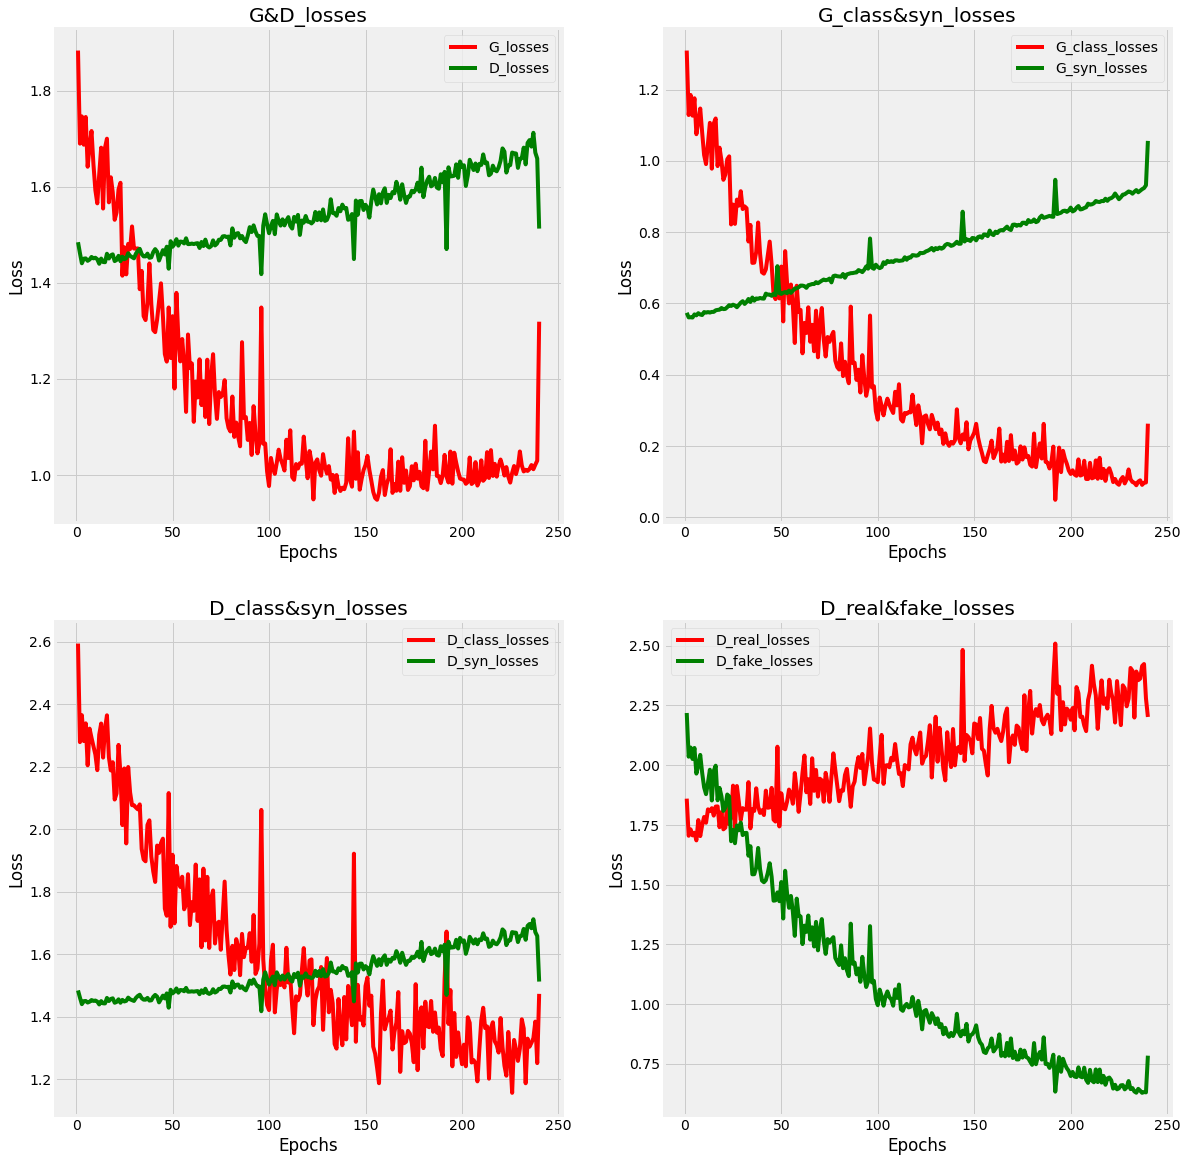

In [30]:
tr_plot(metrics, 0)

In [31]:
def tr_plot(tr_data, start_epoch):
    Epoch_count=len(metrics['Losses']) + start_epoch
    Epochs=[i + 1 for i in range (start_epoch ,Epoch_count)]  
    plt.figure(figsize=(20, 10))
    plt.style.use('fivethirtyeight')
    
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, metrics['Losses'], 'blue', label='Loss')
    plt.title('Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(Epochs, metrics['Accuracy'], 'orange', label='Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()

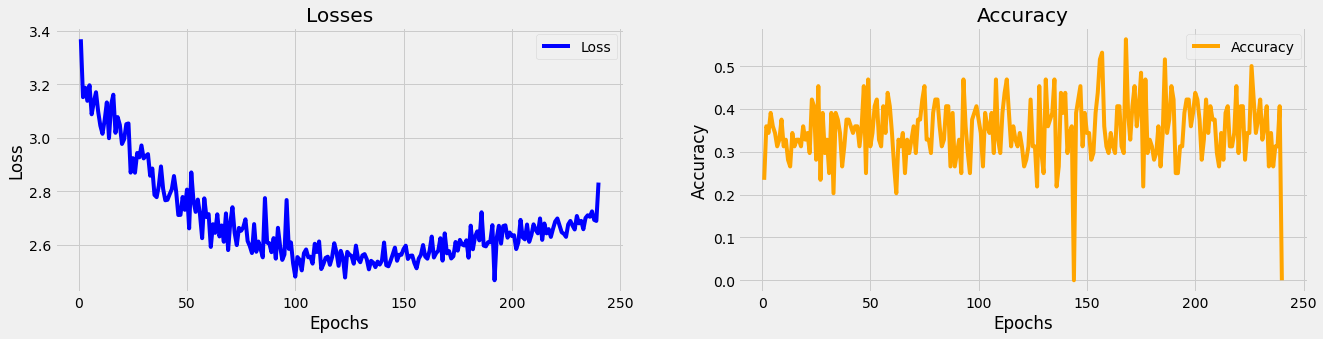

In [32]:
tr_plot(metrics, 0)

In [33]:
def test_gan(generator, discriminator, num_epochs, metrics, loader):
    now = datetime.datetime.now()
    g_losses = metrics['G_losses'][-1]
    d_losses = metrics['D_losses'][-1]
    path='GANAug/output_images/ACGAN'
    try:
        os.mkdir(os.path.join('.', path))
    except Exception as error:
        print(error)

    real_batch = next(iter(loader))
    
    test_img_list = []
    test_noise = torch.randn(batch_size, nz, device=device)
    test_label = torch.randn(batch_size, nb_label, device=device)
    test_fake = generator(test_noise, test_label).detach().cpu()
    test_img_list.append(vutils.make_grid(test_fake, padding=2, normalize=True))

    fig = plt.figure(figsize=(20, 20))
    ax1 = plt.subplot(1,2,1)
    ax1 = plt.axis("off")
    ax1 = plt.title("Real Images")
    ax1 = plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    ax2 = plt.subplot(1,2,2)
    ax2 = plt.axis("off")
    ax2 = plt.title("Fake Images")
    ax2 = plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))
    plt.show()
    fig.savefig('%s/image_%.3f_%.3f_%d_%s.png' %
                   (path, g_losses, d_losses, num_epochs, now.strftime("%Y-%m-%d_%H:%M:%S")))

[Errno 17] File exists: './GANAug/output_images/ACGAN'


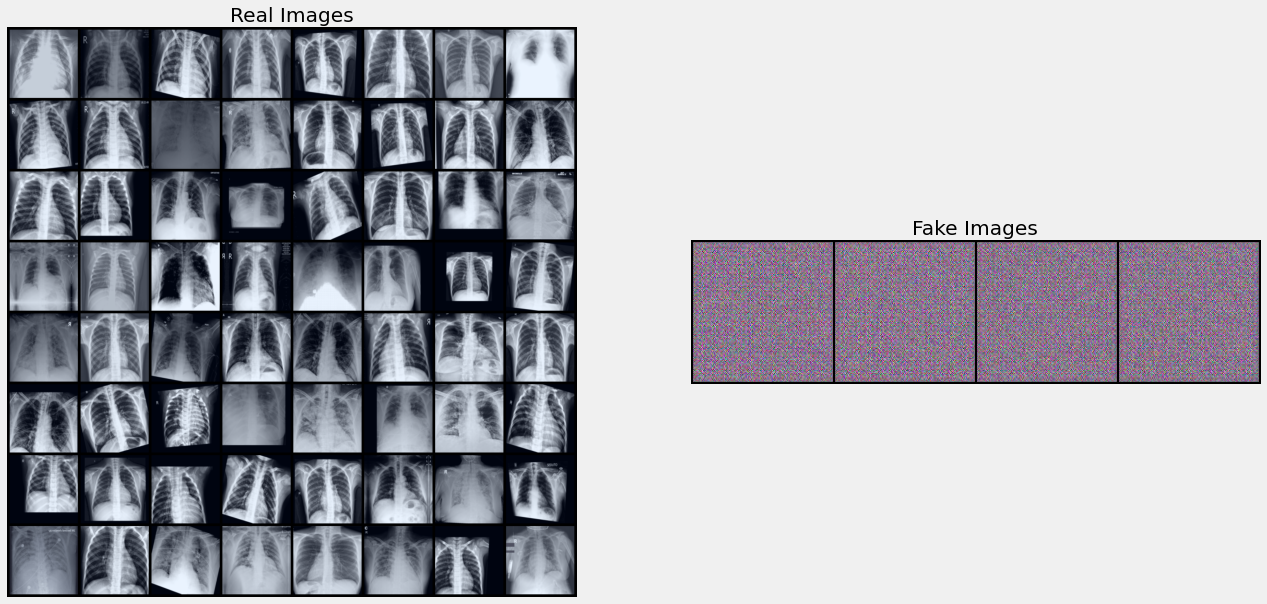

In [34]:
test_gan(generator, discriminator, num_epochs, metrics, train_loader)

In [35]:
def plot_gan(name, train_epoch, values, path, save):
    clear_output(wait=True)
    plt.close('all')
    fig = plt.figure()
    fig = plt.ion()
    fig = plt.subplot(1, 1, 1)
    fig = plt.title('epoch: %s -> %s: %s' % (train_epoch, name, values[-1]))
    fig = plt.ylabel(name)
    fig = plt.xlabel('train_set')
    fig = plt.plot(values)
    fig = plt.grid()
    get_fig = plt.gcf()
    fig = plt.draw()  # draw the plot
    fig = plt.pause(1)  # show it for 1 second
    plt.show()
    if save:
        now = datetime.datetime.now()
        get_fig.savefig('%s/%s_%.3f_%d_%s.png' %
                        (path, name, train_epoch, values[-1], now.strftime("%Y-%m-%d_%H:%M:%S")))

In [38]:
def save_model(generator, discriminator, gen_optimizer, dis_optimizer, metrics, num_epochs):
    now = datetime.datetime.now()
    g_losses = metrics['G_losses'][-1]
    d_losses = metrics['D_losses'][-1]
    path='GANAug/plots/ACGAN/train_%+.3f_%+.3f_%s'% (g_losses, d_losses, now.strftime("%Y-%m-%d_%H-%M-%S"))
    try:
        os.mkdir(os.path.join('.', path))
    except Exception as error:
        print(error)
    plot_gan('G_losses', num_epochs, metrics['G_losses'], path, True)
    plot_gan('D_losses', num_epochs, metrics['D_losses'], path, True)
    plot_gan('G_syn_losses', num_epochs, metrics['G_syn_losses'], path, True)
    plot_gan('G_class_losses', num_epochs, metrics['G_class_losses'], path, True)
    plot_gan('G_syn_losses', num_epochs, metrics['G_syn_losses'], path, True)
    plot_gan('D_class_losses', num_epochs, metrics['D_class_losses'], path, True)
    plot_gan('D_syn_losses', num_epochs, metrics['D_syn_losses'], path, True)
    plot_gan('Losses', num_epochs, metrics['Losses'], path, True)
    plot_gan('Accuracy', num_epochs, metrics['Accuracy'], path, True)

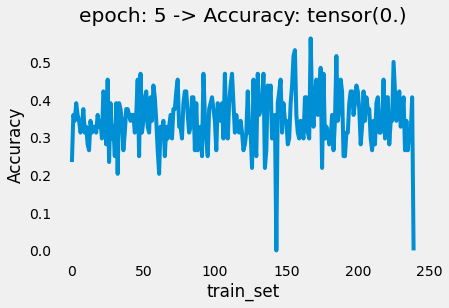

In [39]:
save_model(generator, discriminator, optimizerG, optimizerD, metrics, num_epochs)

Discriminator s tensor([[0.4594],
        [0.4162],
        [0.4162],
        [0.3281]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Discriminator c tensor([[ 0.8867,  0.1722,  0.3266],
        [ 2.2503,  4.0288, -5.4472],
        [-3.0182, -1.2572,  4.8518],
        [ 1.8094, -3.3726,  3.1120]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


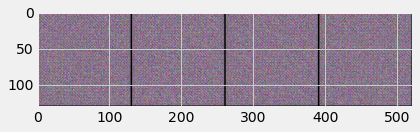

In [40]:
test_img_list = []
test_noise = torch.randn(batch_size, nz, device=device)
test_label = torch.randn(batch_size, nb_label, device=device)
test_img = generator(test_noise, test_label)

s_output, c_label_op = discriminator(test_img.detach().to(device))
print('Discriminator s', s_output)
print('Discriminator c', c_label_op)

test_img = test_img.detach().cpu()
test_img_list.append(vutils.make_grid(test_img, padding=2, normalize=True))
plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))

class label for real tensor([0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 0, 1, 2, 0, 0, 2, 0, 1, 2, 0, 1, 2, 2, 1,
        1, 2, 0, 0, 2, 2, 2, 1, 0, 1, 0, 1, 0, 0, 0, 0, 2, 1, 0, 2, 0, 2, 0, 0,
        0, 2, 1, 2, 0, 2, 1, 0, 2, 2, 2, 1, 2, 1, 0, 0])
Discriminator s tensor([[0.2323],
        [0.1592],
        [0.3989],
        [0.2827],
        [0.3448],
        [0.2996],
        [0.4624],
        [0.4756],
        [0.2106],
        [0.2662],
        [0.2008],
        [0.4100],
        [0.3046],
        [0.2291],
        [0.2435],
        [0.3248],
        [0.3693],
        [0.4678],
        [0.3401],
        [0.3043],
        [0.3064],
        [0.4299],
        [0.3091],
        [0.3975],
        [0.2792],
        [0.3317],
        [0.4275],
        [0.3298],
        [0.4480],
        [0.3306],
        [0.3713],
        [0.3508],
        [0.3469],
        [0.3395],
        [0.2958],
        [0.4326],
        [0.4048],
        [0.2411],
        [0.2563],
        [0.3898],
        [0.4309],
        

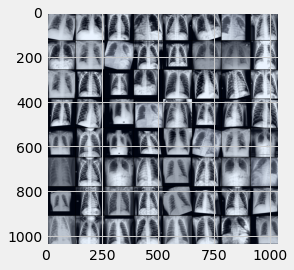

In [43]:
data = next(iter(test_loader))
test_noise, test_class_lable = data
test_img = test_noise
print('class label for real', test_class_lable)

s_output,c_label_op = discriminator(test_img.detach().to(device))
print('Discriminator s', s_output)
print('Discriminator c', c_label_op)

test_img = test_img.detach().cpu()
test_img_list.append(vutils.make_grid(test_img, padding=2, normalize=True))
plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))